In [121]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from os.path import splitext

import random

In [110]:
def predict_mask(img_path, mask_path):
#     img = path + 'pictures/' + file + '.PNG'
#     true_mask = path + 'masks/' + file + '.npy'

    image = Image.open(img_path)
    true_mask = np.load(mask_path)
    net.eval()

    tf = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(image.width),#size[1]),
            transforms.ToTensor()
        ]
    )

    img = torch.from_numpy(BasicDataset.preprocess(image))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

    probs = []
    masks = []
    for i in range(6):
        probs.append(torch.sigmoid(output[:, i, :, :]))
        probs[i] = probs[i].squeeze(0)
        masks.append(probs[i].squeeze().cpu().numpy())

    mask_pred = np.array([masks[i] for i in range(6)])
    
    return image, true_mask, mask_pred

In [111]:
path = '/home/natasha/unet4/axial_data/train/Fifth_3/' 
file = '0423'
img_path = path + 'pictures/' + file + '.PNG'
mask_path = path + 'masks/' + file + '.npy'
image, true_mask, mask_pred = predict_mask(img_path, mask_path)

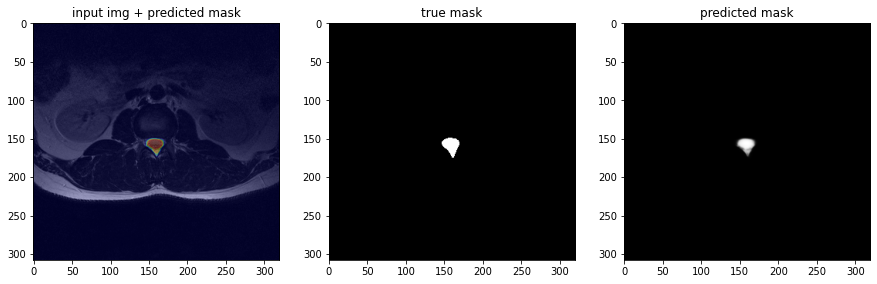

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].imshow(mask_pred[4], cmap='jet', alpha=0.3)
axs[1].imshow(true_mask[:, :, 4], cmap='gray')
axs[2].imshow(mask_pred[4], cmap='gray')
axs[0].set_title('input img + predicted mask')
axs[1].set_title('true mask')
axs[2].set_title('predicted mask')
plt.show()

In [117]:
print(true_mask.shape, mask_pred.transpose((1, 2, 0)).shape)

(308, 320, 6) (308, 320, 6)


In [119]:
 true_mask.shape, mask_pred.shape

((308, 320, 6), (6, 308, 320))

In [138]:
imgs_dir =  '/home/natasha/unet4/axial_data/train/'
folders = os.listdir(imgs_dir)
        
mask_src_paths = []
img_src_paths = []
for i, folder in enumerate(folders):
    path = os.path.join(imgs_dir, folder, 'pictures')
    ids = [splitext(file)[0] for file in os.listdir(path) if not file.startswith('.')]
            
for idx in ids:
    mask_src_paths.append(os.path.join(imgs_dir, folder, 'masks', str(idx)) + '.npy')
    img_src_paths.append(os.path.join(imgs_dir, folder, 'pictures', str(idx)) + '.PNG')
    
iou_general = []
f1_general = []

bad_iou = []
bad_results = []

for i in range(0, len(img_src_pathes)):
    imgname = img_src_paths[i]
    maskname = mask_src_paths[i]
    
    _, true_mask, mask_pred = predict_mask(imgname, maskname)
    
#     img = Image.open(imgname)
#     true_mask = cv2.imread(maskname)

#     mask = predict_img(net=net,
#                        full_img=img,
#                        scale_factor=scale,
#                        out_threshold=mask_threshold,
#                        device=device)

    res_treshold = 0.75 #.75 best for 147th epoch
    mask_pred = np.array([mask_pred[i] > res_treshold for i in range(6)])
    
    d, w, h = mask_pred.shape
    
#     true_mask2 = cv2.resize(true_mask[:,:,0], (h, w))

    pixelThreshold = 0.5
    mask_pred = mask_pred.transpose((1, 2, 0))
    bin_mask = np.where(mask_pred > pixelThreshold, 1, 0)
    
    
    # IoU calculation
    intersection = np.logical_and(bin_mask, true_mask)
    union = np.logical_or(bin_mask,  true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    print(f'IoU is {iou_score}')

    unique, counts = np.unique(bin_mask + true_mask[:, :, 0], return_counts=True)
    print(unique, counts)
    inters = counts[-1]
    union = counts[-1]+counts[-2]

    iou = inters/union

    iou_general.append(iou)

    if iou<0.5:
        bad_iou.append([iou, imgname])

#     squares = 2*h*w
    un, cnts = np.unique(bin_mask, return_counts=True)
    un, cnts2 = np.unique(true_mask2, return_counts=True)
    squares = cnts[1] + cnts2[1]

    f1 = 2 * inters / squares
    f1_general.append(f1)

IoU is 0.5845410628019324


ValueError: operands could not be broadcast together with shapes (308,320,6) (308,320) 